In [1]:
import os
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import random

#!/usr/bin/env python
# coding: utf-8

#!pip install scikit-fdaimport numpy as np
# !pip install scikit-fdaimport numpy as np
import skfda
from matplotlib import pyplot as plt
import numpy as np
# import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import scipy.linalg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
tf.compat.v1.enable_eager_execution()
#np.random.seed(1234)

def full_data(n,t,basis,p):  
    if basis == "fourier" :
        bas = skfda.representation.basis.Fourier(
        n_basis=p,
        domain_range=(min(t), max(t)))
    if basis == "bspline":
        bas = skfda.representation.basis.BSpline(
        n_basis=p,
        domain_range=(min(t), max(t)))
    if basis == "monomimal":
        bas = skfda.representation.basis.monomial(
        n_basis=p,
        domain_range=(min(t), max(t))) 

    coef = np.random.normal(0, 0.5, size = (n,p))
    fd_basis = skfda.FDataBasis(basis=bas, coefficients= coef)

    return [fd_basis.evaluate(t), fd_basis]


### generating basis for weight update
## ln is the first time point, lb is the last one. We can hard code it to be 0 and 1 respectively since our time points are in [0,1]
## q is the number of basis functions
# t2 is the current time point
# t1 is the previous time point



def BasisExpansion(q, t, lb=0, ub=1):
    bas = skfda.representation.basis.BSpline(n_basis=q, domain_range=(lb, ub))
    #bas = skfda.representation.basis.Fourier(n_basis=q, domain_range=(lb, ub))
    Bt = np.squeeze(bas.evaluate(t))
    return Bt



# Generated data

In [536]:

n_train = 100  #     train  sample size
n_test = 100  #     test  sample size
p = 5  # number of basis functions
T = 40  # number of time points
t = np.linspace(0, 1, T)   # tim grid
basis = "fourier"   # choice of first basis
#basis2 = "bspline"  # choice of second basis
h = 32    # hidden layer numbers
activation = 'tanh'  #Activation function selection
lr = 1e-3   #learning rate
epoch = 30
num_layers = 1  #the number of layers
'''
To change the number of hidden layers, change the dimension of B. 
For example, if the number of hidden layers is, 
then B= scipy.linalg.block_diag(Bt, Bt, Bt, Bt, Bt)  
'''


epoch = epoch
batch_size = 32
steps_per_epoch = n_train // batch_size
metric = keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)






# Train date
data_full_train1, data_fd_train1 = full_data(n = n_train, t = t, basis = basis, p = p) ## complete funcitonal data,  data_fd is the same as data_full  - it is just easier to plot
# Test  date
data_full_test1, data_fd_test1 = full_data(n = n_test, t = t, basis = basis, p = p) ## complete funcitonal data,  data_fd is the same as data_full  - it is just easier to plot




In [537]:
from sklearn.preprocessing import normalize

data_full_train1 = np.squeeze(data_full_train1,axis =2)
data_full_train1=normalize(data_full_train1,axis=1,norm='max')
data_full_train1 =np.expand_dims(data_full_train1,axis=-1)

In [538]:
noise_x = np.random.randn(100,40,1) *0.0
noise_y = np.random.randn(100,40,1) *0.0

data_full_train = data_full_train1 + noise_x
data_full_test =data_full_test1 + noise_y

x_full_train = np.delete(data_full_train,[T-1],1)
y_full_train = np.delete(data_full_train,[0],1)
#print(y_full_train)
#y_full_train = y_full_train[:,-1] 
x_full_test = np.delete(data_full_test,[T-1],1)
true_full_test = np.delete(data_full_test,[0],1)




# Prepare train and test

print(x_full_train.shape)
print(y_full_train.shape)
#print(x_full_train)
#print(y_full_train)
print(x_full_test.shape)
print(true_full_test.shape)
# First, let's define a RNN Cell, as a layer subclass.

(100, 39, 1)
(100, 39, 1)
(100, 39, 1)
(100, 39, 1)


In [539]:
def plot(x,y,pred,index):#index:int
    T_=T
    t = np.linspace(0, 1, T_)
    fig,ax=plt.subplots() #canvas size
    ax.plot(t[0:T_-1],y[index],'-',label='True')
    #ax.plot(t[0:T_-1],pred[index],label='Predict')
    #ax.plot(t[0:T_-1],x[index],'-*',label='Features')
    ax.legend()
    ax.set_title('Sample {}'.format(index)) #title
    #ax.set_xlabel('Time step') #x lable
    plt.show()
    

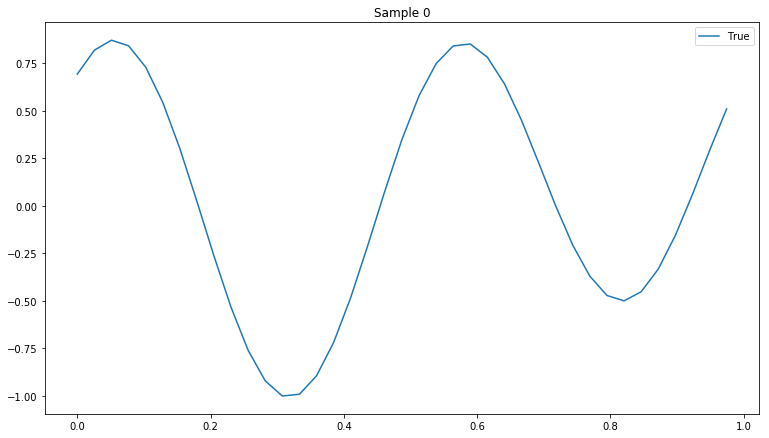

In [540]:
plot(y_full_train,y_full_train,y_full_train,0)

# RNN

In [593]:
class MyRNNCell(keras.layers.Layer):

    def __init__(self, units,
                 activation = None,
                 kernel_initializer='orthogonal',
                 use_bias=True,
                 **kwargs):
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.state_size = units


        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1] + self.units, self.units),
                                 initializer=self.kernel_initializer,
                                 name='W')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer='uniform',
                                        name='bias')

        self.built = True

    def call(self, inputs, states):
        Ht = states[0]
        cat = tf.concat((Ht, inputs), -1)  # Concatenate Ht with input X
        Ht = tf.matmul(cat, self.W)
        #print(Ht.shape)
        if self.use_bias:
            Ht = Ht + self.bias
        if self.activation is not None:
            Ht = self.activation(Ht)

        return Ht, [Ht]



In [ ]:
epoch_list1=[]
loss_list1=[]
model8 = Sequential()

for i in range(num_layers-1):
    model8.add(RNN(MyRNNCelll(h, activation=activation), return_sequences=True))
model8.add(RNN(MyRNNCell(h,activation=activation),return_sequences=True))
model8.add(tf.keras.layers.Dropout(0.2))
model8.add(tf.keras.layers.Dense(1))
'''
model8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history8 = model8.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,decay = 0.01)#optimizer
epoch_list1=[]
loss_list1=[]
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model8(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model8.trainable_variables) #calculate gradients
     #print('before:',grads[0].numpy(),end='\t')

    #grads=[tf.clip_by_value(g,clip_value_min=-1e3, clip_value_max=6e-6, name=None)
           #for g in grads] #gradient clipping
    #print('after:',grads[0].numpy(),end='\t')
    #print('loss:',loss)

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model8.trainable_variables))#update parameters
    
    test_pred = model8(x_full_test)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - true_full_test))#testing set loss
    if e%100==0:
        epoch_list1.append(e)
        loss_list1.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))


# ITV-RNN

In [543]:


class MRNNCell(keras.layers.Layer):

    def __init__(self, units, q,
                 activation=None,
                 kernel_initializer='orthogonal',
                 use_bias=True,
                 **kwargs):
        self.units = units
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.q = q
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.state_size = units
        super(MRNNCell, self).__init__(**kwargs)
        self.k =  np.linspace(0, 1, T)
        self.m = 0
        self.update = 0
        self.steps = T
        
    def build(self, input_shape):
        '''
        self.W = self.add_weight(shape=(input_shape[-1] + self.units, self.units),
                                 initializer=self.kernel_initializer,
                                 name='W')
        '''
        self.Q = self.add_weight(
            shape=(self.units + input_shape[-1] , self.q *self.units),  # theta-matrix to be optimized
            initializer=self.kernel_initializer,
            name='theta')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer='uniform',
                                        name='bias')

        self.built = True

    def call(self, inputs, states):
        # K.clear_session()
        Ht = states[0]
        # h = tf.matmul(inputs, self.W)
        #print(self.k.shape)
        self.t1 = self.k[self.m]
        Bt = BasisExpansion(self.q, self.t1)

        B = Bt
        for i in range(self.units - 1):
            B = scipy.linalg.block_diag(B, Bt)


        self.update = tf.matmul(self.Q, B.T) 
        
        self.BM =self.update  # BM is the external matrix and varies with the time step
        cat = tf.concat((Ht, inputs), -1)  # Concatenate Ht with input X
        Ht = tf.matmul(cat, self.BM)
        #Ht = tf.matmul(St, self.BM)
        if self.use_bias:
            Ht = Ht + self.bias
        if self.activation is not None:
            Ht = self.activation(Ht)
            #St = self.activation(St)
        self.m += 1
        if self.m == self.steps:
            self.m = 0
            self.update = 0

        return Ht, [Ht]


In [ ]:
epoch_list2=[]
loss_list2=[]
model2 = Sequential()

for i in range(num_layers-1):
    model2.add(RNN(MRNNCell(h,q=p, activation=activation), return_sequences=True))
model2.add(RNN(MRNNCell(h,q=p,activation=activation),return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(1))
'''
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history2 = model2.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,decay = 0.01)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model2(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model2.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model2.trainable_variables))#update parameters
    
    test_pred = model2(x_full_test)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - true_full_test))#testing set loss
    if e%100==0:
        epoch_list2.append(e)
        loss_list2.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))



# ETV-RNN

In [545]:
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, q,
                 activation=None,
                 kernel_initializer='orthogonal',
                 use_bias=True,
                 **kwargs):
        self.units = units
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.q = q
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)
        self.k =  np.linspace(0, 1, T)
        self.m = 0
        self.update = 0
        self.steps = T

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1] + self.units, self.units),
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.Q = self.add_weight(
            shape=(self.units, self.q * self.units ),  # theta-matrix to be optimized
            initializer=self.kernel_initializer,
            name='theta')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer='uniform',
                                        name='bias')

        self.built = True

    def call(self, inputs, states):
        # K.clear_session()
        Ht = states[0]
        # h = tf.matmul(inputs, self.W)
        self.t1 = self.k[self.m]
        Bt = BasisExpansion(self.q, self.t1)
        B = Bt
        for i in range(self.units - 1):
            B = scipy.linalg.block_diag(B, Bt)



        self.update = tf.matmul(self.Q, B.T)
        self.BM = self.update          # The Change matrix
        cat = tf.concat((Ht, inputs), -1)  
        Ht = tf.matmul(cat, self.W)
        Ht = tf.matmul(Ht, self.BM)    # Update the Ht
        if self.use_bias:
            Ht = Ht + self.bias
        if self.activation is not None:
            Ht = self.activation(Ht)
            #St = self.activation(St)
        self.m += 1
        if self.m == self.steps:
            self.m = 0
            self.update = 0

        return Ht, [Ht]

In [ ]:
epoch_list3=[]
loss_list3=[]
model3 = Sequential()

for i in range(num_layers-1):
    model3.add(RNN(MinimalRNNCell(h,q=p, activation=activation), return_sequences=True))
model3.add(RNN(MinimalRNNCell(h,q=p,activation=activation),return_sequences=True))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(1))
'''
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history3 = model3.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,decay = 0.01)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model3(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model3.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model3.trainable_variables))#update parameters
    
    test_pred = model3(x_full_test)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - true_full_test))#testing set loss
    if e%100==0:
        epoch_list3.append(e)
        loss_list3.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))


# Show the results

In [595]:
T=39
def plot(true,p1,p2,p3,index):#index:int
    #plt.figure(figsize=(2000,6), dpi=100)
    plt.rcParams['figure.figsize']=(12.8, 7.2)
    #plt.figure( figsize=(12,8), dpi=80 )
    T_=37
    t = np.linspace(0, 37, T_)
    fig,ax=plt.subplots() #canvas size
    #plt.xlim((-1,2))
    #plt.ylim((-1,1))
    ax.plot(t[0:T_],true[index],'-',label='True',lw=3)
    ax.plot(t[0:T_],p1[index],'-.',label='RNN',lw=5)
    ax.plot(t[0:T_],p2[index],':',label='ITV-RNN',lw=3,markersize='10')
    ax.plot(t[0:T_],p3[index],'-p',label='ETV-RNN',lw=3,markersize='10')
    #ax.plot(t[0:T_],true[index],'-')
    #ax.plot(t[0:T_],p1[index],'-^')
    #ax.plot(t[0:T_],p2[index],'-+')
    #ax.plot(t[0:T_],p3[index],'-p')
    #ax.legend(loc='upper left')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    ax.legend(bbox_to_anchor=(0,1.02,1.0,0.5), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, fontsize=25)
    #ax.set_title('Comparison between real data and predicted values of RNN') #title
    #ax.set_aspect(1)
    ax.set_xlabel('Time',fontsize=30) #x lable
    ax.set_ylabel('Value',fontsize=30) #x lable
    plt.savefig("C:\\Users\\HP\\Desktop\\rnn_smooth_short.png")
    plt.show()
   

In [596]:
pred_1=model8(x_full_train)
pred_2=model2(x_full_train)
pred_3=model3(x_full_train)
#@plot(x_full_test,true_full_test,pred,0)

In [597]:
y1 = y_full_train[:,0:-2]
y5 = pred_1[:,1:-1]
y6 = pred_2[:,1:-1]
y7 = pred_3[:,1:-1]

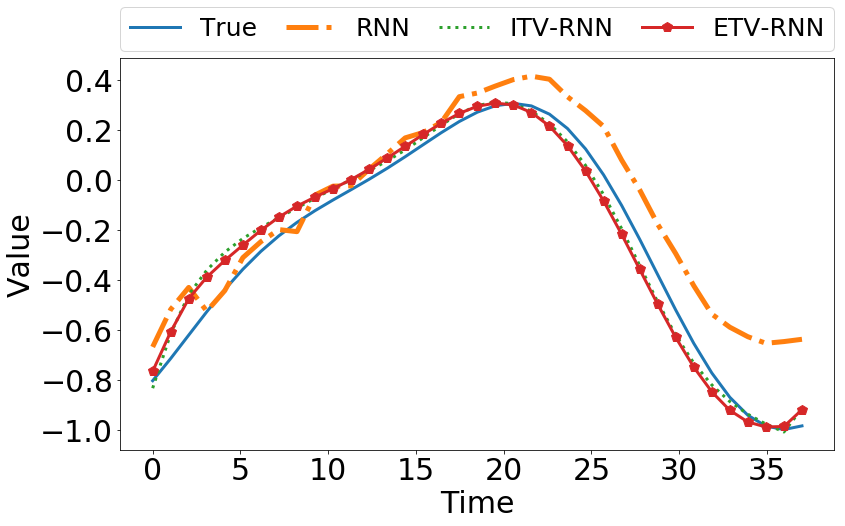

In [598]:
plot(y1,y5,y6,y7,13)

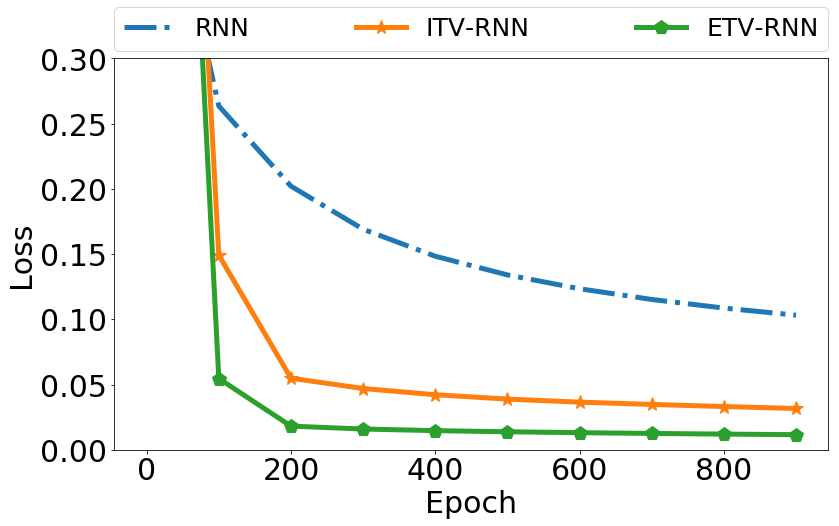

In [592]:
#RNN vs basis testloss comparison chart
import matplotlib.pyplot as plt
fig,ax=plt.subplots() #canvas size
plt.rcParams['figure.figsize']=(12.8, 7.2)
ax.plot(epoch_list1, loss_list1, '-.',label='RNN',lw=5)
ax.plot(epoch_list2, loss_list2, '-*',label='ITV-RNN',lw=5,markersize='15')
ax.plot(epoch_list3, loss_list3, '-p',label='ETV-RNN',lw=5,markersize='15')
ax.legend(bbox_to_anchor=(0,1.02,1.0,0.5), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#ax.set_title('T=20, n_train=500, q=5, units=10') #title
ax.set_xlabel('Epoch',fontsize=30)
ax.set_ylabel('Loss',fontsize=30)
plt.ylim(0.00,0.3)
plt.savefig("C:\\Users\\HP\\Desktop\\lstmloss_0.1.png")
plt.show()

# LSTM

In [599]:
class MYLSTM1(keras.layers.Layer):

    def __init__(self, units,
                 kernel_initializer='orthogonal',
                 **kwargs):
        super(MYLSTM1, self).__init__()
        self.units = units
        self.state_size = units
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        super(MYLSTM1, self).build(input_shape)
        self.Wf = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wf',
                                  trainable=True)

        self.Wi = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wi',
                                  trainable=True)

        self.Wc = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wa',
                                  trainable=True)

        self.Wo = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wo',
                                  trainable=True)

        self.built = True

    def call(self, inputs, states):
        xt = inputs
        Ht = states[0]
        Ct = states[0]
        cat = tf.concat((Ht, xt), -1)             # Concatenate Ht with input X
        Ft = tf.sigmoid(tf.matmul(cat, self.Wf))  # Forget gate
        It = tf.sigmoid(tf.matmul(cat, self.Wi))  # Input gate
        Gt = tf.sigmoid(tf.matmul(cat, self.Wc))
        Ct = It * Gt + Ft * Ct                    # Update the Ct
        Ot = tf.tanh(tf.matmul(cat, self.Wo))     # Output gate
        Ht = Ot * tf.tanh(Ct)                     # Update the Ht
        Ct = tf.tanh(Ct)
        return Ht, [Ct]

In [ ]:
epoch_list4=[]
loss_list4=[]
model5 = Sequential()

for i in range(num_layers-1):
    model5.add(RNN(MYLSTM1(h, activation=activation), return_sequences=True))
model5.add(RNN(MYLSTM1(h,activation=activation),return_sequences=True))
model5.add(tf.keras.layers.Dropout(0.2))
model5.add(tf.keras.layers.Dense(1))
'''
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history5 = model5.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,decay = 0.01)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model5(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model5.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model5.trainable_variables))#update parameters
    
    test_pred = model5(x_full_test)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - true_full_test))#testing set loss
    if e%100==0:
        epoch_list4.append(e)
        loss_list4.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))


# ITV-LSTM

In [601]:
class MYLSTM_1(keras.layers.Layer):

    def __init__(self, units, q,
                 kernel_initializer='orthogonal',
                 **kwargs):
        super(MYLSTM_1, self).__init__()
        self.units = units
        self.state_size = units
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.q = q
        self.k = np.linspace(0, 1, T)
        self.m = 0
        self.t = 0
        self.update = 0
        self.steps = T

    def build(self, input_shape):
        super(MYLSTM_1, self).build(input_shape)
        self.Q1 = self.add_weight(shape=(input_shape[-1] + self.units, self.q * self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wf',
                                  trainable=True)

        self.Q2 = self.add_weight(shape=(input_shape[-1] + self.units, self.q * self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wi',
                                  trainable=True)

        self.Q3 = self.add_weight(shape=(input_shape[-1] + self.units, self.q * self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wc',
                                  trainable=True)

        self.Q4 = self.add_weight(shape=(input_shape[-1] + self.units, self.q * self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wo',
                                  trainable=True)

        # self.U = self.add_weight(
        # shape=(self.units, self.units),
        # initializer='uniform',
        # name='U')
        '''
        self.Q = self.add_weight(
            shape=(self.units, self.q * self.units),  
            initializer=self.kernel_initializer,
            name='theta')

        self.Q2 = self.add_weight(
            shape=(self.units, self.q * self.units), 
            initializer=self.kernel_initializer,
            name='theta2')
        '''
        self.built = True

    def call(self, inputs, states):
        # K.clear_session()
        xt = inputs
        Ht = states[0]
        Ct = states[0]

        self.t1 = self.k[self.m]
        Bt = BasisExpansion(self.q, self.t1)
        B = Bt
        for i in range(self.units - 1):
            B = scipy.linalg.block_diag(B, Bt)

        self.update = tf.matmul(self.Q1, B.T)
        self.BM = self.update                      #Change matrix 1
        self.BM2 = tf.matmul(self.Q2, B.T)         #Change matrix 2
        self.BM3 = tf.matmul(self.Q3, B.T)
        self.BM4 = tf.matmul(self.Q4, B.T)
        

        cat = tf.concat((Ht, xt), -1)             # Concatenate Ht with input X
        Ft = tf.sigmoid(tf.matmul(cat, self.BM))  # Forget gate
        It = tf.sigmoid(tf.matmul(cat, self.BM2))  # Input gate
        Gt = tf.sigmoid(tf.matmul(cat, self.BM3))
        Ct = It * Gt + Ft * Ct                    # Update the Ct
        Ot = tf.tanh(tf.matmul(cat, self.BM4))     # Output gate
        Ht = Ot * tf.tanh(Ct)                     # Update the Ht
        Ct = tf.tanh(Ct)
        
        
        
        '''
        cat = tf.concat((Ht, inputs), -1)         # Concatenate Ht with input X
        Ft = tf.sigmoid(tf.matmul(cat, self.BM))  # Forget gate
        It = tf.sigmoid(tf.matmul(cat, self.BM2))  # Input gate
        Gt = tf.sigmoid(tf.matmul(cat, self.BM3))
        Ct = It * Gt + Ft * Ct  # update the Ct
        Ot = tf.tanh(tf.matmul(cat, self.BM4))     # Output  gate
        # Ht = Ot * tf.tanh(Ct)
        # Ct = tf.matmul(Ct, self.U)
        St = Ot * tf.tanh(Ct)
        Ht = tf.tanh(tf.matmul(St, self.BM))       # update the Ht
        Ct = tf.tanh(tf.matmul(Ct, self.BM2))      # update the Ct
        # Ct = tf.tanh(Ct)
        # print(Ct)
        '''
        self.m += 1
        if self.m == self.steps:
            self.m = 0
            self.update = 0

        return Ht, [Ct]
        

In [ ]:
epoch_list5=[]
loss_list5=[]
model6 = Sequential()

for i in range(num_layers-1):
    model6.add(RNN(MYLSTM_1(h, q=p,activation=activation), return_sequences=True))
model6.add(RNN(MYLSTM_1(h,q=p,activation=activation),return_sequences=True))
model6.add(tf.keras.layers.Dropout(0.2))
model6.add(tf.keras.layers.Dense(1))
'''
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history5 = model5.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,decay = 0.01)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model6(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model6.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model6.trainable_variables))#update parameters
    
    test_pred = model6(x_full_test)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - true_full_test))#testing set loss
    if e%100==0:
        epoch_list5.append(e)
        loss_list5.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))

# ETV-LSTM

In [603]:
class MYLSTM_2(keras.layers.Layer):

    def __init__(self, units, q,
                 kernel_initializer='orthogonal',
                 **kwargs):
        super(MYLSTM_2, self).__init__()
        self.units = units
        self.state_size = units
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.q = q
        self.k = np.linspace(0, 1, T)
        self.m = 0
        self.t = 0
        self.update = 0
        self.steps = T

    def build(self, input_shape):
        super(MYLSTM_2, self).build(input_shape)
        self.Wf = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wf',
                                  trainable=True)

        self.Wi = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wi',
                                  trainable=True)

        self.Wc = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wc',
                                  trainable=True)

        self.Wo = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wo',
                                  trainable=True)

        # self.U = self.add_weight(
        # shape=(self.units, self.units),
        # initializer='uniform',
        # name='U')

        self.Q = self.add_weight(
            shape=(self.units, self.q * self.units),  
            initializer=self.kernel_initializer,
            name='theta')

        self.Q2 = self.add_weight(
            shape=(self.units, self.q * self.units), 
            initializer=self.kernel_initializer,
            name='theta2')

        self.built = True

    def call(self, inputs, states):
        # K.clear_session()
        xt = inputs
        Ht = states[0]
        Ct = states[0]

        self.t1 = self.k[self.m]
        Bt = BasisExpansion(self.q, self.t1)
        B = Bt
        for i in range(self.units - 1):
            B = scipy.linalg.block_diag(B, Bt)

        self.update = tf.matmul(self.Q, B.T)
        self.BM = self.update                      #Change matrix 1
        self.BM2 = tf.matmul(self.Q2, B.T)         #Change matrix 2
        cat = tf.concat((Ht, inputs), -1)         # Concatenate Ht with input X
        Ft = tf.sigmoid(tf.matmul(cat, self.Wf))  # Forget gate
        It = tf.sigmoid(tf.matmul(cat, self.Wi))  # Input gate
        Gt = tf.sigmoid(tf.matmul(cat, self.Wc))
        Ct = It * Gt + Ft * Ct  # update the Ct
        Ot = tf.tanh(tf.matmul(cat, self.Wo))     # Output  gate
        # Ht = Ot * tf.tanh(Ct)
        # Ct = tf.matmul(Ct, self.U)
        St = Ot * tf.tanh(Ct)
        Ht = tf.tanh(tf.matmul(St, self.BM))       # update the Ht
        Ct = tf.tanh(tf.matmul(Ct, self.BM2))      # update the Ct
        # Ct = tf.tanh(Ct)
        # print(Ct)
        self.m += 1
        if self.m == self.steps:
            self.m = 0
            self.update = 0

        return Ht, [Ct]

In [ ]:
epoch_list6=[]
loss_list6=[]
model7 = Sequential()

for i in range(num_layers-1):
    model7.add(RNN(MYLSTM_2(h,q=p), return_sequences=True))
model7.add(RNN(MYLSTM_2(h,q=p),return_sequences=True))
model7.add(tf.keras.layers.Dropout(0.2))
model7.add(tf.keras.layers.Dense(1))
'''
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history7 = model7.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,decay = 0.01)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model7(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model7.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model7.trainable_variables))#update parameters
    
    test_pred = model7(x_full_test)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - true_full_test))#testing set loss
    if e%100==0:
        epoch_list6.append(e)
        loss_list6.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))

In [609]:
T=39
def plot(true,p1,p2,p3,index):#index:int
    #plt.figure(figsize=(2000,6), dpi=100)
    plt.rcParams['figure.figsize']=(12.8, 7.2)
    plt.figure( figsize=(12,8), dpi=80 )
    #T_=T
    T_=37
    t = np.linspace(0, 37, T_)
    fig,ax=plt.subplots() #canvas size
    #plt.xlim((-1,2))
    #plt.ylim((-1,1))
    
    ax.plot(t[0:T_],true[index],'-',label='True',lw=3)
    ax.plot(t[0:T_],p1[index],'-.',label='LSTM',lw=5)
    ax.plot(t[0:T_],p2[index],':',label='ITV-LSTM',lw=3,markersize='10')
    ax.plot(t[0:T_],p3[index],'-p',label='ETV-LSTM',lw=3,markersize='10')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.legend(bbox_to_anchor=(0,1.02,1.0,0.5), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, fontsize=25)
    '''
    ax.plot(t[0:T_],true[index],'-')
    ax.plot(t[0:T_],p1[index],'-^')
    ax.plot(t[0:T_],p2[index],'-+')
    ax.plot(t[0:T_],p3[index],'-p')
    '''
    #ax.set_title('Comparison between real data and predicted values of RNN') #title
    #ax.set_aspect(1)
    ax.set_xlabel('Time ',fontsize=30) #x lable
    ax.set_ylabel('Value',fontsize=30) #x lable
    plt.savefig("C:\\Users\\HP\\Desktop\\lstm_smooth_short.png")
    plt.show()
   

# Show the results

In [610]:
pred_4=model5(x_full_train)
pred_5=model6(x_full_train)
pred_6=model7(x_full_train)

In [611]:
y1 = y_full_train[:,0:-2]
y2 = pred_4[:,1:-1]
y3 = pred_5[:,1:-1]
y4 = pred_6[:,1:-1]


<Figure size 960x640 with 0 Axes>

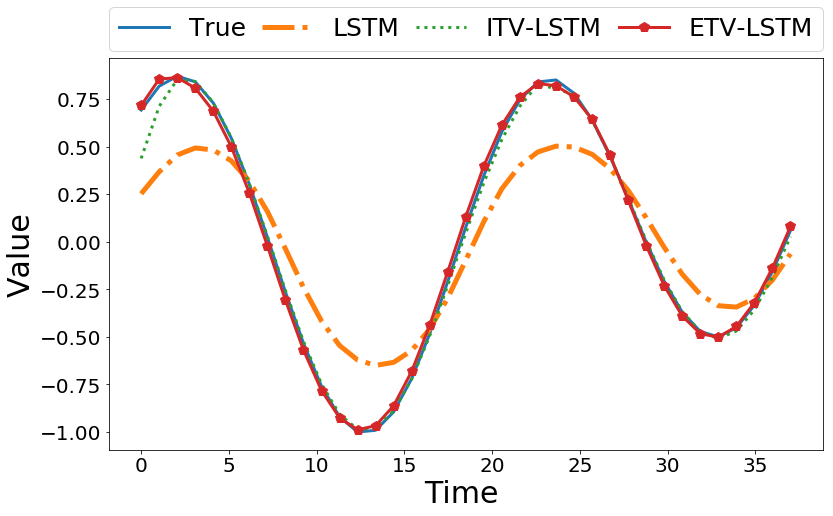

In [612]:
plot(y1,y2,y3,y4,0)

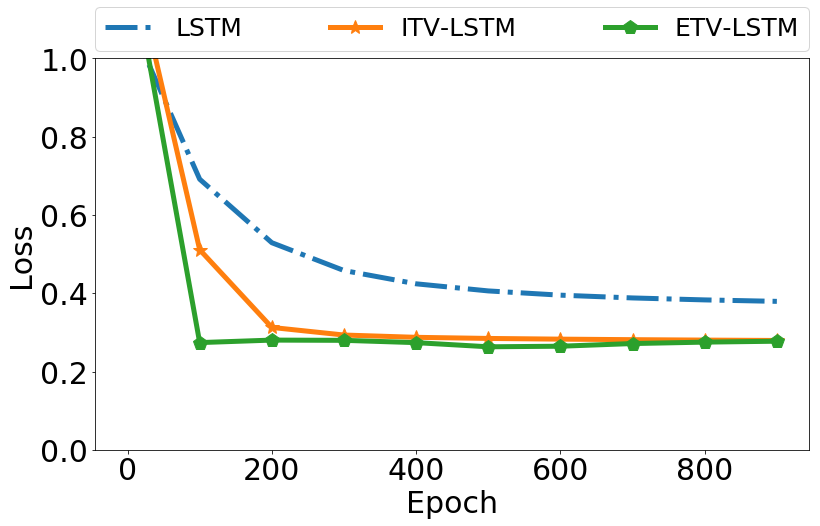

In [508]:
#RNN vs basis testloss comparison chart
import matplotlib.pyplot as plt
fig,ax=plt.subplots() #canvas size
plt.rcParams['figure.figsize']=(12.8, 7.2)
ax.plot(epoch_list6, loss_list4, '-.',label='LSTM',lw=5)
ax.plot(epoch_list6, loss_list5, '-*',label='ITV-LSTM',lw=5,markersize='15')
ax.plot(epoch_list6, loss_list6, '-p',label='ETV-LSTM',lw=5,markersize='15')
ax.legend(bbox_to_anchor=(0,1.02,1.0,0.5), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#ax.set_title('T=20, n_train=500, q=5, units=10') #title
ax.set_xlabel('Epoch',fontsize=30)
ax.set_ylabel('Loss',fontsize=30)
plt.ylim(0,1.0)
plt.savefig("C:\\Users\\HP\\Desktop\\lstmloss_0.5.png")
plt.show()